In [48]:
import os
import glob
import re
import geopandas as gpd
import startinpy
import numpy as np
import rasterio
from rasterio.fill import fillnodata
from scipy.interpolate import NearestNDInterpolator
from shapely.geometry import mapping
from rasterio.features import geometry_mask
from functions import write_output
import tqdm
import fiona

def get_bbox(raster_paths):
    bboxes = []
    for raster_path in raster_paths:
        with rasterio.open(raster_path) as src:
            bbox = src.bounds
            bboxes.append(bbox)
    left = max([bbox.left for bbox in bboxes])
    bottom = max([bbox.bottom for bbox in bboxes])
    right = min([bbox.right for bbox in bboxes])
    top = min([bbox.top for bbox in bboxes])
    return rasterio.coords.BoundingBox(left, bottom, right, top)

def crop_raster(raster_path, bbox, no_data=-9999):
    with rasterio.open(raster_path) as src:
        window = src.window(bbox.left, bbox.bottom, bbox.right, bbox.top)

        # Read the data for the specified window
        cropped_data = src.read(window=window)

        # Read the full mask for the entire dataset
        full_mask = src.read_masks(1)

        # Ensure window attributes are integers
        row_off = int(window.row_off)
        col_off = int(window.col_off)
        height = int(window.height)
        width = int(window.width)

        # Slice the mask to match the window dimensions
        cropped_mask = full_mask[row_off:row_off + height, col_off:col_off + width]

        # Replace no-data values in the data
        if src.nodata is not None:
            cropped_data[cropped_data == src.nodata] = no_data
        return cropped_data, src.window_transform(window), src.crs, cropped_mask

In [21]:
def extract_center_cells(cropped_data, mask, no_data=-9999):
    # Get coordinates of center cells
    cropped_data = cropped_data[0, :, :]

    # Get the indices of the rows and columns
    rows, cols = np.indices(cropped_data.shape)
    
    # Identify corner coordinates
    corners = {
        "top_left": (0, 0),
        "top_right": (0, cropped_data.shape[1] - 1),
        "bottom_left": (cropped_data.shape[0] - 1, 0),
        "bottom_right": (cropped_data.shape[0] - 1, cropped_data.shape[1] - 1)
    }
    
    # Mask for valid center cells (non-no_data and mask is valid)
    valid_center_cells = (cropped_data != no_data) & (mask != 0)

    # Extract x, y, z values for valid cells
    x_valid = cols[valid_center_cells]
    y_valid = rows[valid_center_cells]
    z_valid = cropped_data[valid_center_cells]
    
    # Create interpolator from valid points
    interpolator = NearestNDInterpolator(list(zip(x_valid, y_valid)), z_valid)
    
    # Check each corner for no data and interpolate if necessary
    for corner_name, (row, col) in corners.items():
        if cropped_data[row, col] == no_data:
            # Interpolate the nearest valid value
            cropped_data[row, col] = interpolator((col, row))
    
    # Extract non-no_data and valid mask center cells again after filling corners
    valid_center_cells = (cropped_data != no_data) & (mask != 0)

    # Extract final x, y, z values after filling corners
    x_filled = cols[valid_center_cells]
    y_filled = rows[valid_center_cells]
    z_filled = cropped_data[valid_center_cells]
    
    # Prepare final list of [x, y, z]
    xyz_filled = []
    for x_i, y_i, z_i in zip(x_filled, y_filled, z_filled):
        xyz_filled.append([x_i, y_i, z_i])

    return xyz_filled



In [40]:
def fill_raster(cropped_data, dt):
    new_data = np.copy(cropped_data)

    # for interpolation, grid of all column and row positions, excluding the first and last rows/cols
    cols, rows = np.meshgrid(
        np.arange(1, cropped_data.shape[2] - 1),
        np.arange(1, cropped_data.shape[1] - 1)
    )

    # flatten the grid to get a list of all (col, row) locations
    locs = np.column_stack((cols.ravel(), rows.ravel()))

    # laplace interpolation
    interpolated_values = dt.interpolate({"method": "Laplace"}, locs)

    # reshape interpolated grid back to og
    interpolated_grid = np.reshape(interpolated_values, (cropped_data.shape[1] - 2, cropped_data.shape[2] - 2))

    # fill new_data with interpolated values
    new_data[0, 1:-1, 1:-1] = interpolated_grid

    return new_data[0, 1:-1, 1:-1]

In [46]:
chm_path = "output/25GN2/CHM_25GN2_12.TIF"
dtm_path = "data/DTM_ams.TIF"
dsm_path = "data/DSM_ams.TIF"
buildings_path =  "data/ams_buildings.gpkg"
output_base_folder = "tryout"
nodata_value =-9999

In [52]:
layers = fiona.listlayers(buildings_path)
buildings = gpd.read_file(buildings_path, layer = "25GN2")

In [57]:
def load_buildings(buildings_path):
     buildings_gdf = gpd.read_file(buildings_path, layer = "25GN2")
     return [mapping(geom) for geom in buildings_gdf.geometry]


In [66]:
raster_paths = [dtm_path, chm_path, dsm_path]
overlapping_bbox = get_bbox(raster_paths)

# Cropping rasters to bbox
dtm_cropped, dtm_transform, dtm_crs, dtm_mask = crop_raster(dtm_path, overlapping_bbox, no_data=nodata_value)
dsm_cropped, dsm_transform, dsm_crs, dsm_mask = crop_raster(dsm_path, overlapping_bbox, no_data=nodata_value)
chm_cropped, _, _, _ = crop_raster(chm_path, overlapping_bbox, no_data=nodata_value)

In [9]:
dtm_cropped.shape

(1, 2580, 2080)

In [12]:
bbox = [0, 0, 2079, 2579]

In [24]:
points = extract_center_cells(dtm_cropped, dtm_mask, no_data=nodata_value)

In [25]:
dt = startinpy.DT()

In [26]:
dt.insert(points, "BBox")

In [41]:
test_data = fill_raster(dtm_cropped, dt)

In [43]:
dtm_cropped.size

5366400

In [44]:
test_data.size

5357084

In [45]:
write_output(rasterio.open(dtm_path), test_data, dtm_transform, "tryout/testing.TIF")

File written to 'tryout/testing.TIF'


In [67]:
points_buildings = extract_center_cells(dsm_cropped, dsm_mask, no_data=nodata_value)
dt_buildings = startinpy.DT()

In [68]:
dt_buildings.insert(points_buildings, "BBox")

In [69]:
dsm_data = fill_raster(dsm_cropped, dt_buildings)

In [71]:
def replace_buildings(filled_dtm, dsm_buildings, buildings_geometries, transform, nodata_value=-9999):
    
    building_mask = geometry_mask(buildings_geometries, transform=transform, invert=False, out_shape=filled_dtm.shape)

    # Apply the mask to the filled DTM
    final_dtm = np.where((building_mask), filled_dtm, dsm_buildings)

    return final_dtm

In [58]:
building_geometry = load_buildings(buildings_path)

In [72]:
finished_data = replace_buildings(test_data, dsm_data, building_geometry, dtm_transform)

In [78]:
write_output(rasterio.open(dtm_path), dsm_data, dtm_transform, "tryout/build.TIF")

File written to 'tryout/build1.TIF'


In [73]:
write_output(rasterio.open(dtm_path), finished_data, dtm_transform, "tryout/testingbuild.TIF")

File written to 'tryout/testingbuild.TIF'


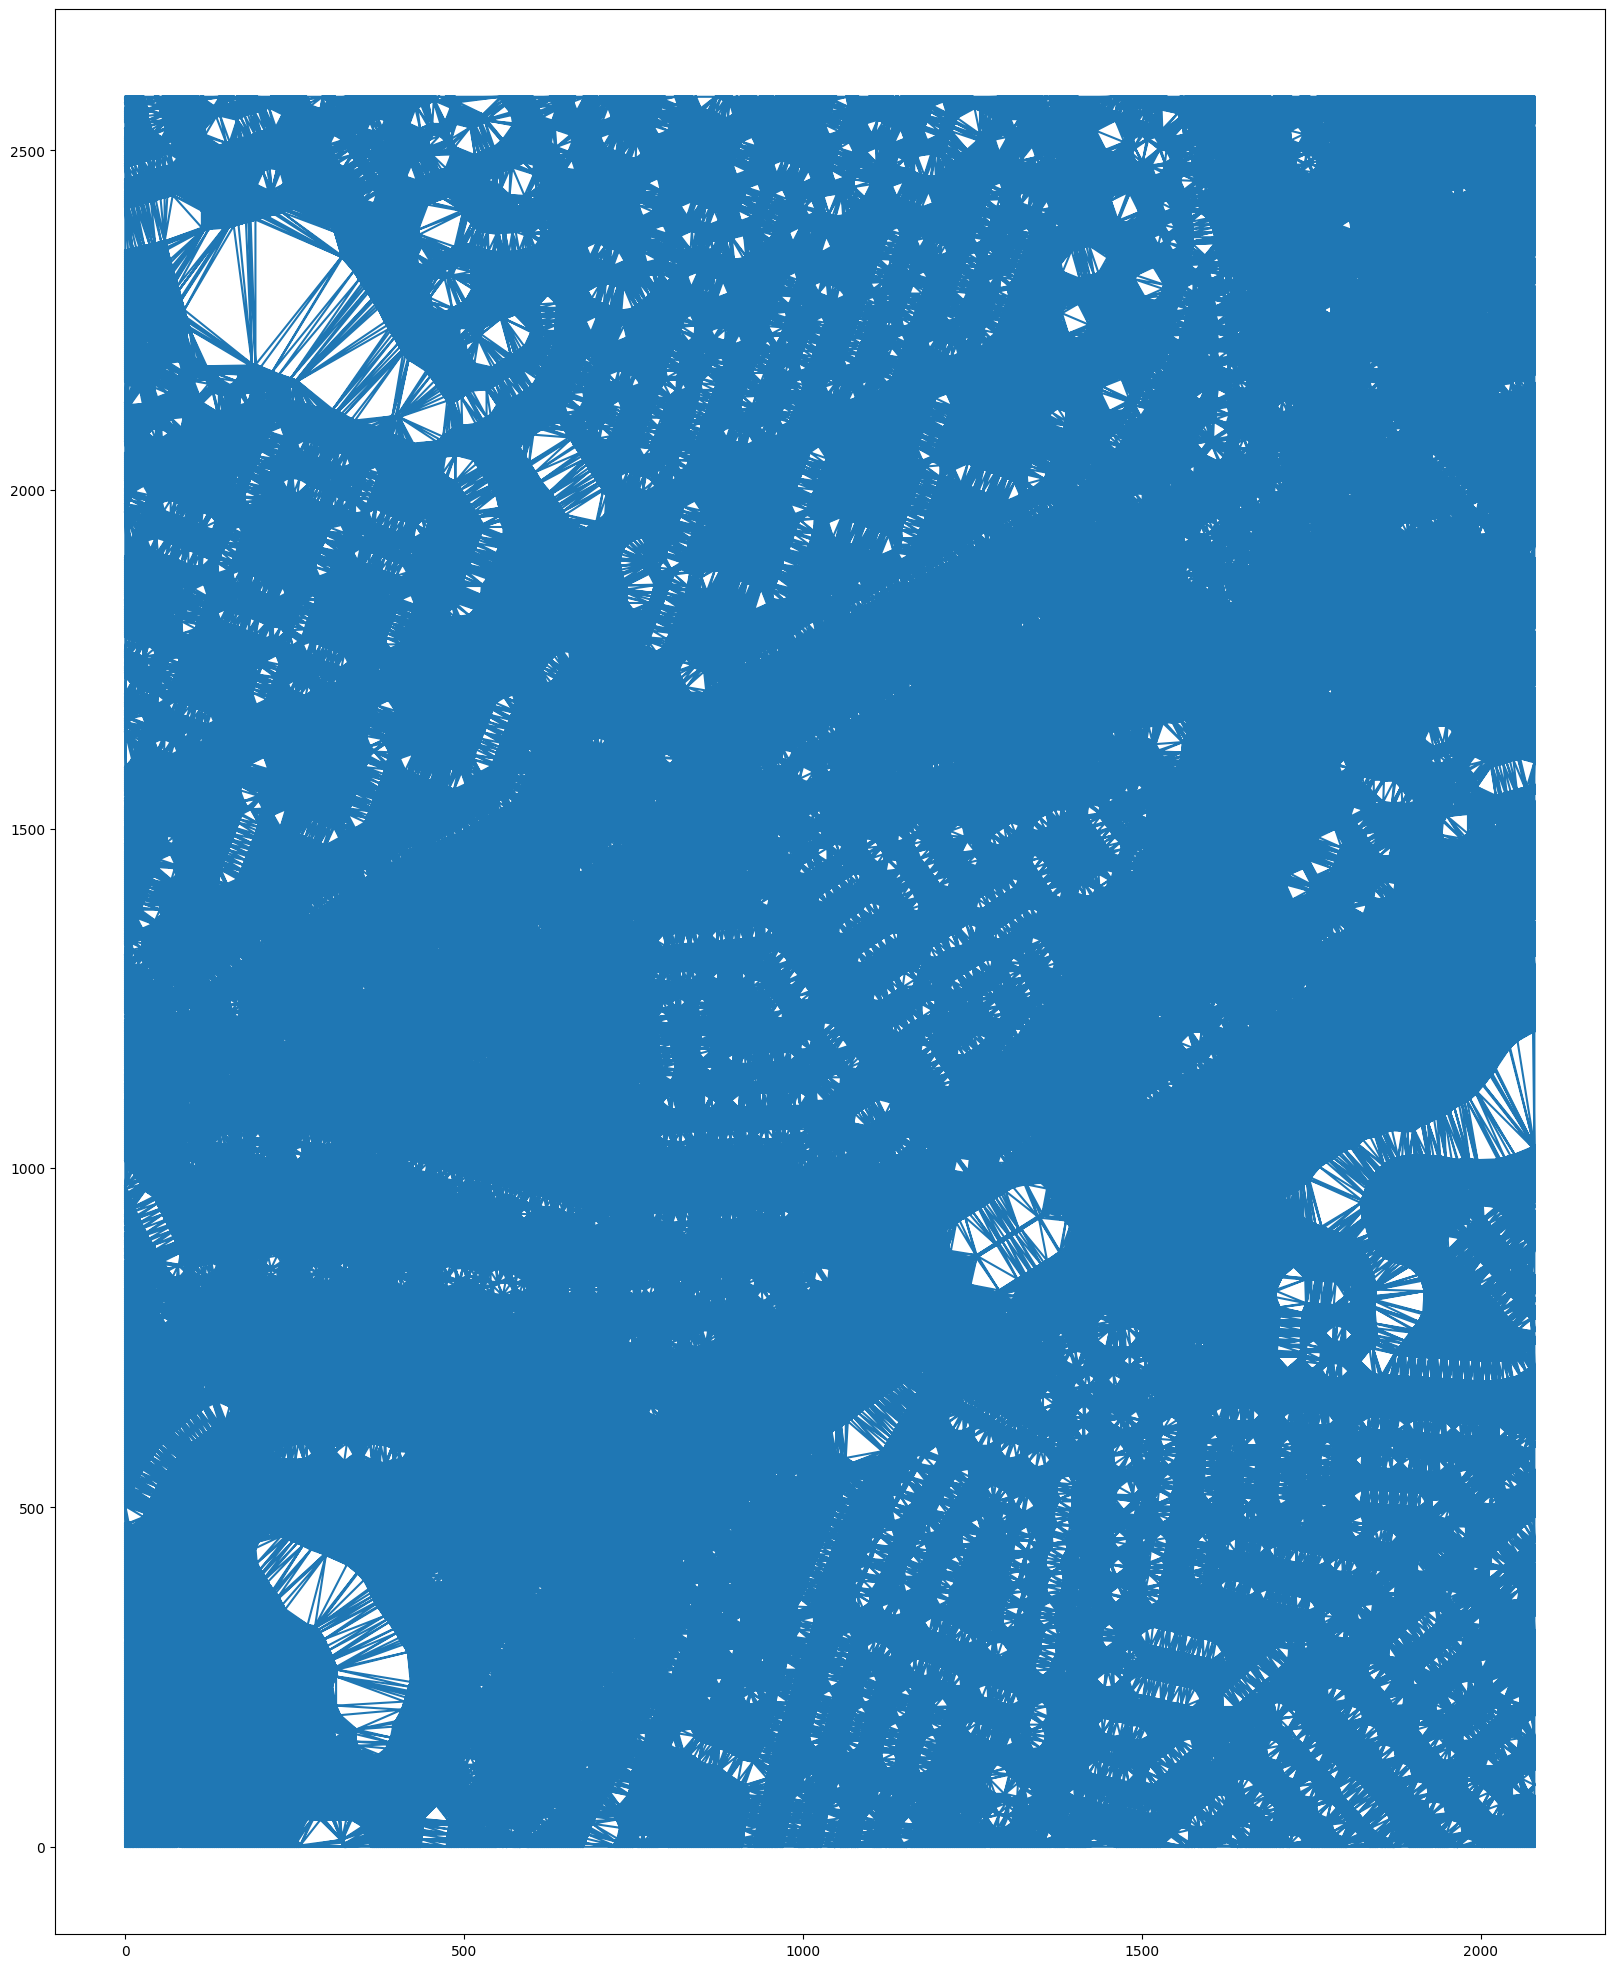

In [11]:

#-- plot
import matplotlib.pyplot as plt
pts = dt.points
trs = dt.triangles

# Create a new figure with a specified size (width, height) in inches
plt.figure(figsize=(20, 25))  # Adjust the size as needed

# Plot the triangles
plt.triplot(pts[:, 0], pts[:, 1], trs)

# Plot the points, skipping the vertex "0"
# plt.plot(pts[1:, 0], pts[1:, 1], 'o')

# Show the plot
plt.show()